# elastic scattering

Let’s start by running {{bfrescox}} on a simple example: proton elastic scattering off a $^{78}$ Ni target at a laboratory energy of 50 MeV. To do this, we’ll make use of the built-in **template**  generator provided by {{bfrescox}} to set up the reaction and build a full {{frescox}} **input file**. This system is part of the canonical set of examples provided in the [{{fresco}}](https://www.fresco.org.uk/examples/index.html) website.

This example is based off this standard {{frescox}} example: [fresco.org.uk/examples/B1-example-el.in](https://www.fresco.org.uk/examples/B1-example-el.in)

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd
import json

with open("MatplotlibEsthetics.json", "r") as fptr:
    esthetics = json.load(fptr)

plt.style.use(esthetics["style"])
FONTSIZE      = esthetics["fontsize"]
TICK_FONTSIZE = esthetics["tick_fontsize"]
MARKERSIZE    = esthetics["markersize"]
LINEWIDTH     = esthetics["linewidth"]

In [2]:
# Folder to which all frescox input/output files will be written to
EXAMPLE_DIR = Path.cwd().joinpath("78Ni_p_elastic_example")
if EXAMPLE_DIR.exists():
    shutil.rmtree(EXAMPLE_DIR)
os.mkdir(EXAMPLE_DIR)

## Generating the template

{{bfrescox}} provides the functionality to generare {{frescox}} input files from templates, which is an otherwise valid {{frescox}} input file, with certain numerical values replaced with strings like `@param_name@`. The function `Configuration.from_template` takes in a file path to such a template, and a dictionary of the parameter values to fill in (e.g. `{"param_name" : 12}`, which, as one might guess, would replace `@param_name@` with the number 12, and returns a `Configuration` instance, which specifies a valid {{frescox}} input.

One can then use `bfrescox.run_simulation` to run it, and `bfrescox.parse_fort16` to parse the resulting cross sections. This is exactly what we will be doing in this example!

However, doing all this requires having a valid {{frescox}} input file template already. Alternatively, {{bfrescox}} can generate such a template based on a users problem specification (currently, this is only supported for elastic and inelastic scattering). We will also demonstrate this capability using `bfrescox.generate_elastic_template`.

So, to summarize, the steps we will follow are:
1. generate a template using `bfrescox.generate_elastic_template`
2. fill in the template to generate a valid {{frescox}} configuration using `bfrescox.Configuration.from_template`
3. run {{frescox}} for this configuration using `bfrescox.run_simulation`
4. parse the output using `bfrescox.parse_fort16`

### Step 1: create the {{bfrescox}} template

`bfrescox.generate_elastic_template` creates a template file based on a system specification which leaves as template parameters all of the parameters related to the target-projectile interaction.

In [3]:
import bfrescox

system_spec =  {
          "target_mass_amu" : 78,
          "target_atomic_number" : 28,
          "target_spin" : 0,
          "projectile_mass_amu" : 1,
          "projectile_atomic_number" : 1,
          "projectile_spin" : "1/2",
          "E_lab_MeV": 50.0,
          "J_tot_min": 0.0,
          "J_tot_max": 60.0,
          "R_match_fm": 60.0,
          "E_0_MeV": 0.0,
          "step_size_fm": 0.1,
          "reaction_name": "p+Ni78 Coulomb + Nuclear"
}

TEMPLATE_PATH = EXAMPLE_DIR.joinpath("78Ni_p_elastic_example.template")
bfrescox.generate_elastic_template(
    TEMPLATE_PATH, **system_spec
)

We now have generated the {{bfrescox}} **template** for the system! Let's see what this looks like.

In [4]:
with open(TEMPLATE_PATH, "r") as temp:
    generated_content = temp.read()

print("Generated Bfrescox Template:")
print("-----------------------------------")
print(generated_content)

Generated Bfrescox Template:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.100000000 rmatch=60.000000000
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=1.000000000 zp=1.000000000
            namet='target'   masst=78.000000000 zt=28.000000000 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &partition /

 &POT kp=1 ap=1.000000000 at=78.000000000 rc=@rC@  /
 &POT kp=1 type=1  p1=@V@ p2=@r@ p3=@a@ p4=@W@ p5=@rw@ p6=@aw@ /
 &POT kp=1 type=2  p1=@Vs@ p2=@rs@ p3=@as@ p4=@Ws@ p5=@rws@ p6=@aws@ /
 &POT kp=1 type=3  p1=@Vso@ p2=@rso@ p3=@aso@ p4=@Wso@ p5=@rwso@ p6=@awso@ /

 &pot /
 &overlap /
 &coupling /



Great! All system quantities are now defined and in place for the reaction we want to run. The parameter **placeholders** are put in place, each one is labeled as `@<parameter name>@` in the **template**.

The generated template has filled in our problem specification, but left as template parameters the parameters of the target-projectile interaction. This includes the parameters `V`, `r`, `a`; users familiar with optical potentials will immediately recognize these as depth, reduced radii, and diffuseness, respecitvely, of a Woods-Saxon potential. The other parameters similarily specify the imaginary part of this potential (`W`, `rw`, `aw`), the real and imaginary surface-peaked potentials (`Vs`, `rs`, `as`, `Ws`, `rws`, `aws`), the real and imaginary spin-orbit potential (`Vso`, `rso`, `aso`, `Wso`, `rwso`, `awso`), and the reduced Coulomb radius `rC`. 

Using `generate_elastic_template` thus makes it easy to set up a fitting or uncertainty-quantification problem relating to these interaction parameters.


#### Note for {{frescox}} users:
All the template parameters in our generated template are in the `&POT` namelists of the input file. {{frescox}} users will be familiar with how this speficiation works, others can find the full documenation here: https://www.fresco.org.uk/xinput7a/frescox-namelist-manual/node8.html.

### Step 2: fill in the template

If you wanted to, you could fill in specific interaction parameters in this template by hand. {{bfrescox}} gives us the functionality to fill them in in the `Configuration` class.


In [5]:
elastic_optical_model_parameters = {
    "rC":  1.2,
    "V":  40.0, "r":   1.2, "a":   0.65, "W":  10.0, "rw":   1.2, "aw":   0.5,
    "Vs":  0,   "rs":  1.2, "as":  0.5,  "Ws":  0,   "rws":  1.2, "aws":  0.5,
    "Vso": 0,   "rso": 1.0, "aso": 0.65, "Wso": 0,   "rwso": 1.0, "awso": 0.65   
}

cfg = bfrescox.Configuration.from_template(
    TEMPLATE_PATH,
    EXAMPLE_DIR.joinpath("frescox.in"),
    elastic_optical_model_parameters,
    overwrite=True,
)

We now have generated a fully valid {{frescox}} **input file** from the **template**! Any working {{frescox}} installation should be able to run this.

Let's see what this looks like.

In [6]:
with open(EXAMPLE_DIR.joinpath("frescox.in"), "r") as input:
    generated_content = input.read()

print("Generated Frescox Input:")
print("-----------------------------------")
print(generated_content)

Generated Frescox Input:
-----------------------------------
p+Ni78 Coulomb + Nuclear
NAMELIST
&FRESCO hcm=0.100000000 rmatch=60.000000000
    jtmin=0.0 jtmax=60.0 absend= 0.01
  thmin=0.00 thmax=180.00 thinc=1.00
    iter=0 ips=0.0 iblock=0 chans=1 smats=2  xstabl=1
  wdisk=2
    elab(1)=50.000000000 treneg=1 /

 &PARTITION namep='projectile' massp=1.000000000 zp=1.000000000
            namet='target'   masst=78.000000000 zt=28.000000000 qval=-0.000 nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0000 cpot=1 jt=0.0 bandt=1 et=0.000000000 /
 &partition /

 &POT kp=1 ap=1.000000000 at=78.000000000 rc=1.200000000  /
 &POT kp=1 type=1  p1=40.000000000 p2=1.200000000 p3=0.650000000 p4=10.000000000 p5=1.200000000 p6=0.500000000 /
 &POT kp=1 type=2  p1=0.000000000 p2=1.200000000 p3=0.500000000 p4=0.000000000 p5=1.200000000 p6=0.500000000 /
 &POT kp=1 type=3  p1=0.000000000 p2=1.000000000 p3=0.650000000 p4=0.000000000 p5=1.000000000 p6=0.650000000 /

 &pot /
 &overlap /
 &coupling /



## Step 3: Running {{frescox}}

Now that we have generated the {{frescox}} **input file**, running the elastic scattering calculation is extremely easy!

In [7]:
bfrescox.run_simulation(cfg, EXAMPLE_DIR.joinpath("frescox.out"), cwd=EXAMPLE_DIR)

Done! All we need to do is parse the results and extract the physical quantities we want. Let's focus on extracting the cross sections from the **output files**.

## Step 4: Parsing the output
For this particular scattering system setup, {{frescox}} writes the ratio to Rutheford cross sections fo the **fort.16** file.  Let's extract those cross sections for our example case as a DataFrame.

In [8]:
fort16_df = bfrescox.parse_fort16(EXAMPLE_DIR.joinpath("fort.16"))
r2R_df = fort16_df["channel_1"]

Let's see what the cross sections look like!

In [9]:
display(r2R_df.head())

,Theta,sigma
0,0.01,1.0000
1,1.00,0.9956
2,2.00,0.9106
3,3.00,0.7792
4,4.00,0.6609


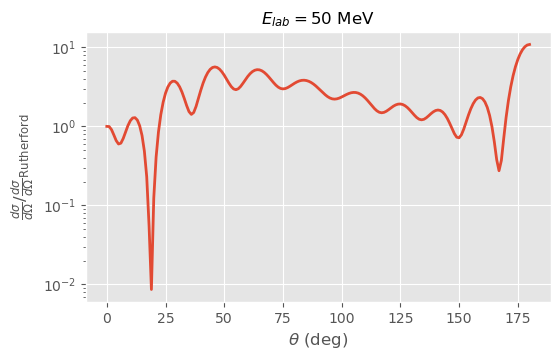

In [10]:
fig = plt.figure(1, figsize=(6, 3.5))

subp = fig.add_subplot(111)
subp.set_title(r"$E_{lab} = 50$ MeV", fontsize=FONTSIZE)
subp.plot(r2R_df.Theta, r2R_df.sigma, lw=LINEWIDTH)
subp.set_yscale('log')
subp.set_ylabel(r"$\frac{d\sigma}{d\Omega} / \frac{d\sigma}{d\Omega}_\text{Rutherford}$", fontsize=FONTSIZE)
subp.set_xlabel(r"$\theta$ (deg)", fontsize=FONTSIZE)
subp.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)